In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image as PILImage
from IPython.display import display, Image as IPImage
from keras.preprocessing.image import load_img, img_to_array, array_to_img
import keras.applications.xception as xception

# Function to extract image name without extension
def extract_image_name(filename):
    return os.path.splitext(filename)[0]

def generate_and_display_gradcam(img_path, model_builder, last_conv_layer_name, preprocess_input, img_size=(299, 299), alpha=0.4, cam_path="save_cam_image.jpg", original_name=None):
    # Load image
    def get_img_array(img_path, size):
        img = load_img(img_path, target_size=size)
        array = img_to_array(img)
        array = np.expand_dims(array, axis=0) #進行維度擴充，以符合模型的預設大小
        return array

    # Generate Grad-CAM heatmap
    def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
        grad_model = tf.keras.models.Model(
            [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
        )  #建立了一個新的 Keras 模型 grad_model，其輸入是原始模型的輸入，而輸出是最後一個卷積層的輸出和模型的最終輸出

        #自動微分工具，用來計算出最後一個卷積層輸出的梯度
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(img_array) #同時獲得最後一個卷積層的特徵圖和模型的預測結果
            if pred_index is None:
                pred_index = tf.argmax(preds[0])  #預測結果中的最高機率類別
            class_channel = preds[:, pred_index]   #選擇目標類別的預測分數

        grads = tape.gradient(class_channel, last_conv_layer_output) #計算出class_channel相對於last_conv_layer_output的重要性，表示每個像素在該類別中的重要性
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)) #對梯度在高度與寬度方向取平均，得到全局平均梯度

        last_conv_layer_output = last_conv_layer_output[0] #移除批次維度，成為3D tensor

        #生成特徵圖
        #將每個通道的梯度與特徵圖相乘並沿通道方向求和，生成類別激活圖
        cam = tf.reduce_sum(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
        #用 ReLU將負值設為 0
        cam = tf.nn.relu(cam)
        #將 CAM 正規化到 [0, 1]，以便可視化
        heatmap = cam / tf.reduce_max(cam)
        return heatmap.numpy() #轉為

    # Save and display Grad-CAM:存取在code所位於的目錄
    def save_and_display_gradcam(img_path, heatmap, cam_path="save_cam_image.jpg", alpha=0.4):
        img = load_img(img_path)
        img = img_to_array(img)

        heatmap = np.uint8(255 * heatmap)

        # 獲取 "jet" 顏色映射並應用到熱力圖
        jet = mpl.cm.get_cmap("jet")
        jet_colors = jet(np.arange(256))[:, :3]

        #忽略 alpha 通道
        jet_heatmap = jet_colors[heatmap]

        jet_heatmap = array_to_img(jet_heatmap)

        #調整熱力圖大小以匹配原始圖像的尺寸
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))

        jet_heatmap = img_to_array(jet_heatmap)

        Superimposed_img = jet_heatmap * alpha + img

        # 將疊加結果轉換為圖像格式並保存
        Superimposed_img = array_to_img(Superimposed_img)

        Superimposed_img.save(cam_path)
        display(IPImage(cam_path))

  
    #各函式依順序執行
    # Preprocess and prepare the image
    img_array = preprocess_input(get_img_array(img_path, size=img_size))

    # Make model with imagenet dataset
    model = model_builder(weights="imagenet")
    model.layers[-1].activation = None

    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Save and display Grad-CAM
    save_and_display_gradcam(img_path, heatmap, cam_path=cam_path, alpha=alpha)


會生成GradCAM colorbar的函式(需要colorbar時再跑，平常用不到)

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image as PILImage
from IPython.display import display, Image as IPImage
from keras.preprocessing.image import load_img, img_to_array, array_to_img
import keras.applications.xception as xception

# Function to extract image name without extension
def extract_image_name(filename):
    return os.path.splitext(filename)[0]

def generate_and_display_gradcam(img_path, model_builder, last_conv_layer_name, preprocess_input, img_size=(299, 299), alpha=0.4, cam_path="save_cam_image.jpg", original_name=None):
    # Load image
    def get_img_array(img_path, size):
        img = load_img(img_path, target_size=size)
        array = img_to_array(img)
        array = np.expand_dims(array, axis=0) #進行維度擴充，以符合模型的預設大小
        return array

    # Generate Grad-CAM heatmap
    def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
        grad_model = tf.keras.models.Model(
            [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
        )  #建立了一個新的 Keras 模型 grad_model，其輸入是原始模型的輸入，而輸出是最後一個卷積層的輸出和模型的最終輸出

        #自動微分工具，用來計算出最後一個卷積層輸出的梯度
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(img_array) #同時獲得最後一個卷積層的特徵圖和模型的預測結果
            if pred_index is None:
                pred_index = tf.argmax(preds[0])  #預測結果中的最高機率類別
            class_channel = preds[:, pred_index]   #選擇目標類別的預測分數

        grads = tape.gradient(class_channel, last_conv_layer_output) #計算出class_channel相對於last_conv_layer_output的重要性，表示每個像素在該類別中的重要性
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)) #對梯度在高度與寬度方向取平均，得到全局平均梯度

        last_conv_layer_output = last_conv_layer_output[0] #移除批次維度，成為3D tensor

        #生成特徵圖
        #將每個通道的梯度與特徵圖相乘並沿通道方向求和，生成類別激活圖
        cam = tf.reduce_sum(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
        #用 ReLU將負值設為 0
        cam = tf.nn.relu(cam)
        #將 CAM 正規化到 [0, 1]，以便可視化
        heatmap = cam / tf.reduce_max(cam)
        return heatmap.numpy() #轉為

    # Save and display Grad-CAM:存取在code所位於的目錄
    def save_and_display_gradcam(img_path, heatmap, cam_path="save_cam_image.jpg", alpha=0.4):
        img = load_img(img_path)
        img = img_to_array(img)

        heatmap = np.uint8(255 * heatmap)

        # 獲取 "jet" 顏色映射並應用到熱力圖
        jet = mpl.cm.get_cmap("jet")
        jet_colors = jet(np.arange(256))[:, :3]

        #忽略 alpha 通道
        jet_heatmap = jet_colors[heatmap]

        jet_heatmap = array_to_img(jet_heatmap)

        #調整熱力圖大小以匹配原始圖像的尺寸
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))

        jet_heatmap = img_to_array(jet_heatmap)

        Superimposed_img = jet_heatmap * alpha + img

        # 將疊加結果轉換為圖像格式
        Superimposed_img = array_to_img(Superimposed_img)
        
        # 使用 Matplotlib 繪製帶有 colorbar 的熱力圖
        fig, ax = plt.subplots()
        ax.imshow(Superimposed_img)
        ax.axis("off")  # 隱藏座標軸

        # 在新圖層繪製熱力圖並加上 colorbar
        heatmap_overlay = ax.imshow(heatmap, cmap="jet", alpha=0.4)
        plt.colorbar(heatmap_overlay, ax=ax, fraction=0.046, pad=0.04)  # 添加 colorbar

        # 保存並展示圖片
        plt.savefig(cam_path, bbox_inches="tight", pad_inches=0.0)
        plt.show()

    #各函式依順序執行
    # Preprocess and prepare the image
    img_array = preprocess_input(get_img_array(img_path, size=img_size))

    # Make model with imagenet dataset
    model = model_builder(weights="imagenet")
    model.layers[-1].activation = None

    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Save and display Grad-CAM
    save_and_display_gradcam(img_path, heatmap, cam_path=cam_path, alpha=alpha)


執行大函式中包的三小函式

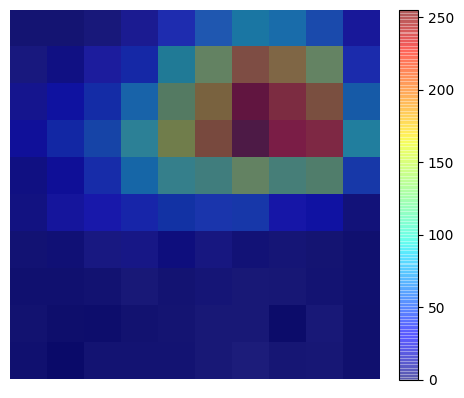

In [2]:
output_png_path = r'E:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_8_13\test_FOR_YOUR_LIFE\cal_png\00020_c8_frame51.png'

# Call the function with required parameters
generate_and_display_gradcam(
    img_path=output_png_path,
    model_builder=xception.Xception,
    last_conv_layer_name="block14_sepconv2_act",
    preprocess_input=xception.preprocess_input,  
    img_size=(299, 299),
    alpha=0.4,
    cam_path="save_cam_image.jpg"
)

把整個folder的file都用gradCAM處理過

In [3]:
import sys
sys.path.append(r"E:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\reqiured_funcs") #存取所需函式的路徑


In [ ]:
from del_files import delete_files_in_directory

output_dir = r'E:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_dentalCalculus\CAL_png\dental_calculus_profile'

# 方便刪除檔案的code，慎用
delete_files_in_directory(output_dir)


每張OCT加gradCAM:成功(耗時37min)

In [ ]:
import glob

# Process all images in the specified directory
# imgs_path = glob.glob(r'E:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_8_13\test_png\cal\*.png')
imgs_path = glob.glob(r'E:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_8_13\test_FOR_YOUR_LIFE\cal_png\*.png')
model_builder = xception.Xception  # Replace with your model
last_conv_layer_name = 'block14_sepconv2_act'  # Replace with the name of the last convolutional layer in your model
preprocess_input = xception.preprocess_input


#建存cam影像目錄
# cam_path = r'E:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_8_13\test_png\cal_CAM'
cam_path = r'E:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_8_13\test_FOR_YOUR_LIFE\cal_CAM'
os.makedirs(cam_path, exist_ok=True)

def extract_image_name(filename):
    return os.path.splitext(filename)[0]

# Loop through all image paths and generate Grad-CAM for each
for img_path in imgs_path:
    img_name = extract_image_name(os.path.basename(img_path))
    cam_output_path = os.path.join(cam_path, f'{img_name}_cam.jpg')
    # print(cam_output_path)
    generate_and_display_gradcam(img_path, model_builder, last_conv_layer_name, preprocess_input, cam_path=cam_output_path)

處理Nor

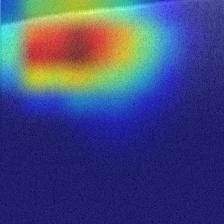

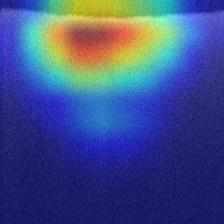

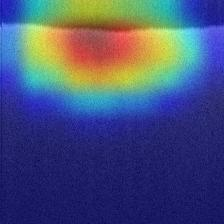

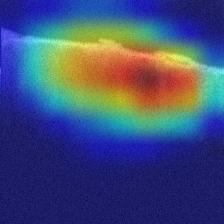

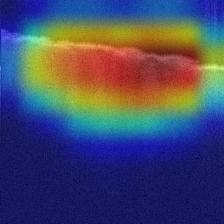

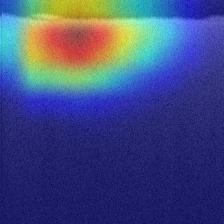

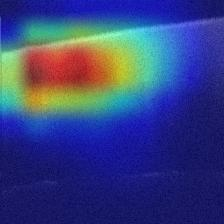

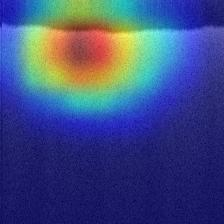

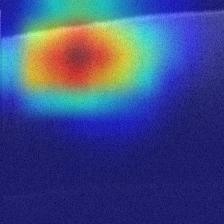

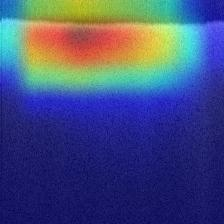

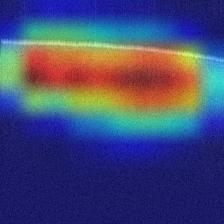

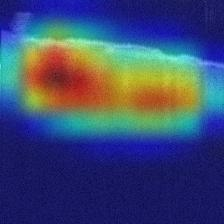

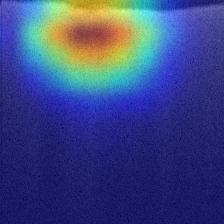

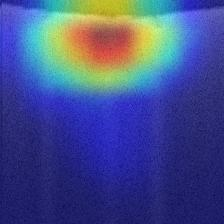

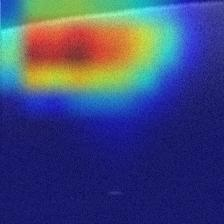

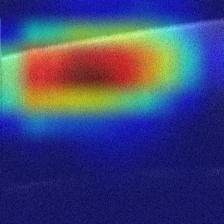

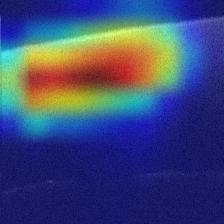

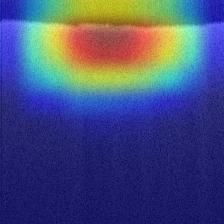

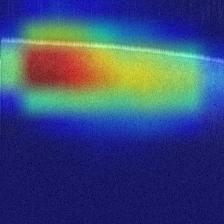

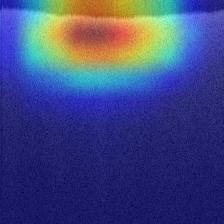

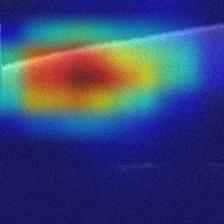

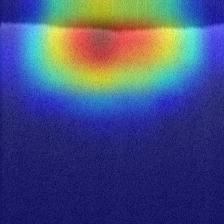

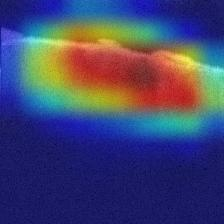

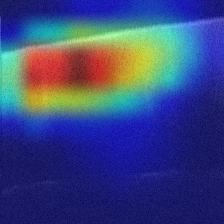

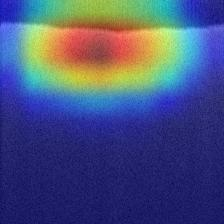

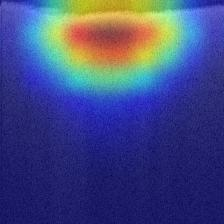

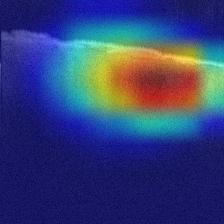

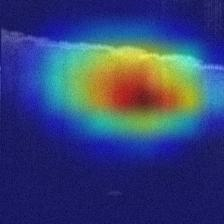

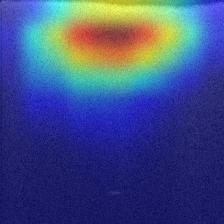

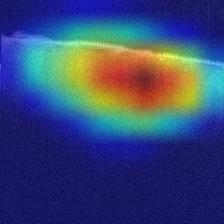

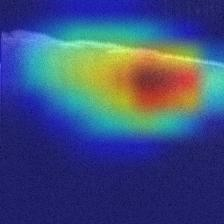

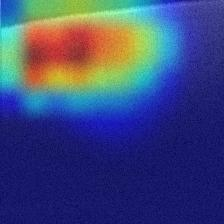

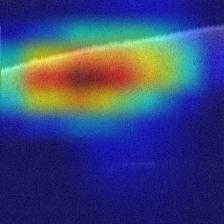

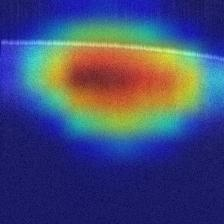

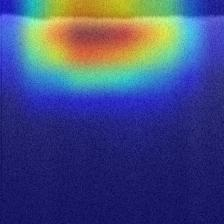

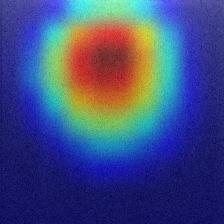

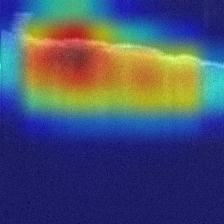

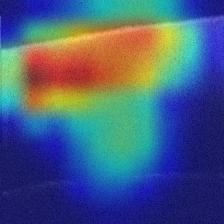

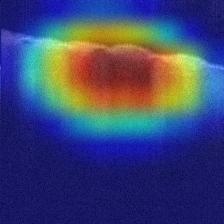

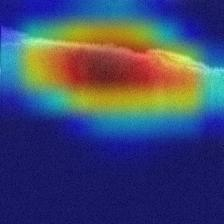

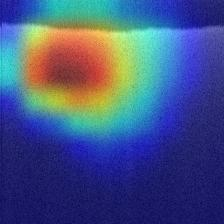

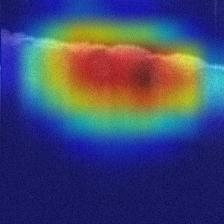

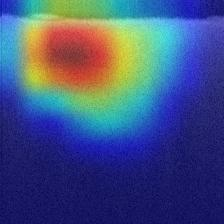

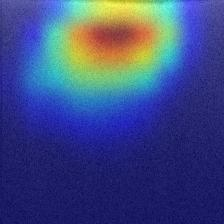

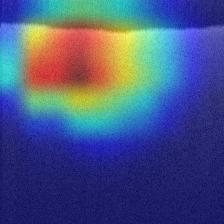

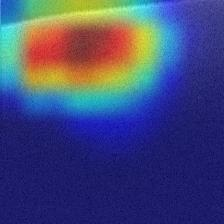

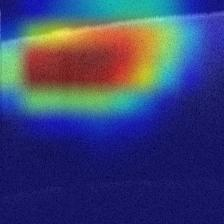

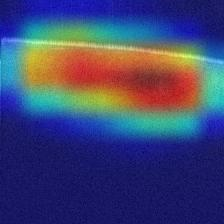

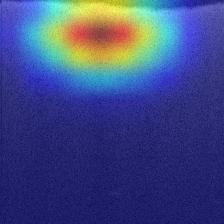

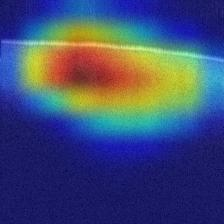

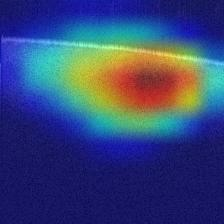

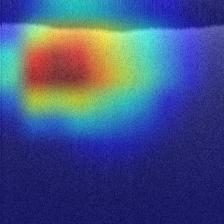

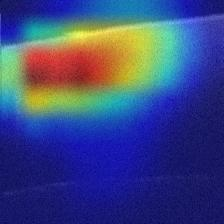

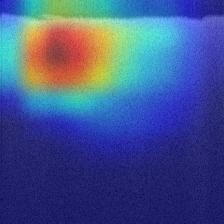

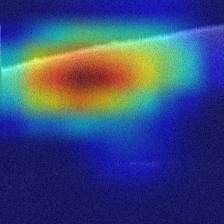

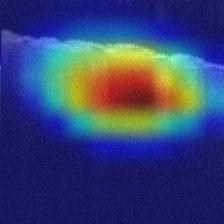

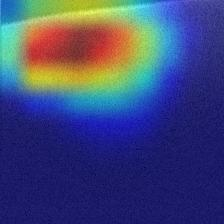

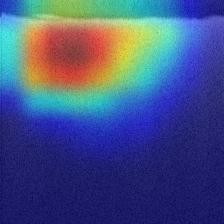

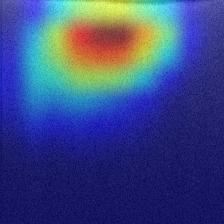

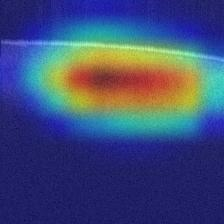

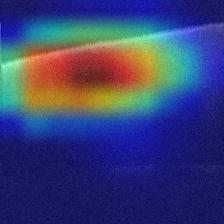

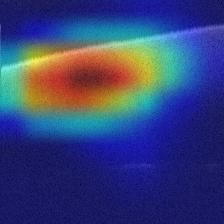

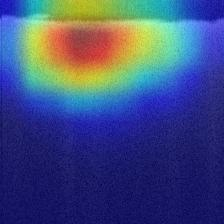

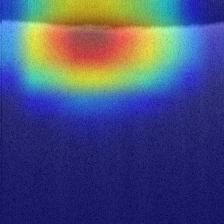

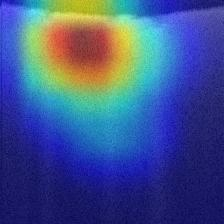

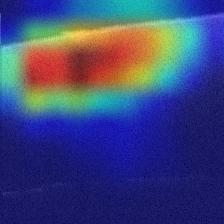

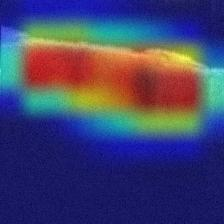

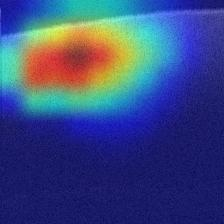

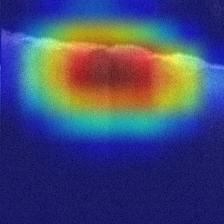

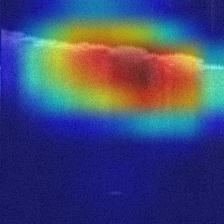

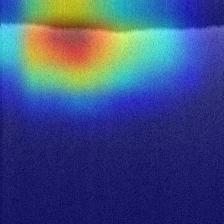

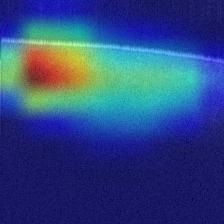

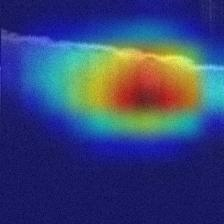

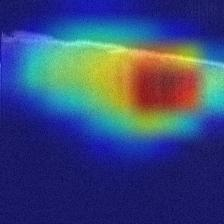

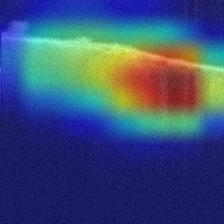

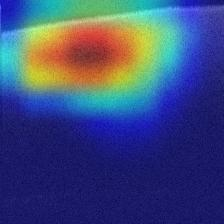

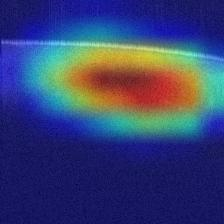

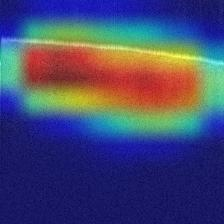

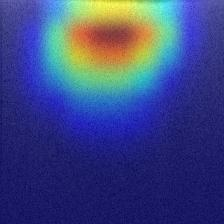

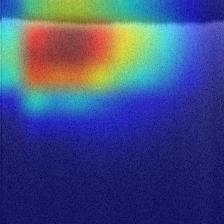

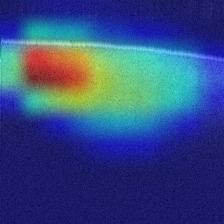

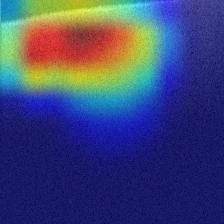

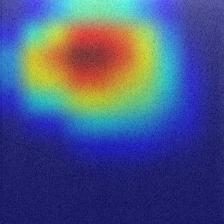

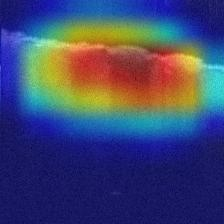

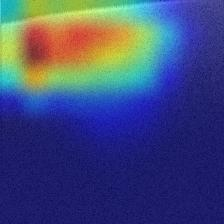

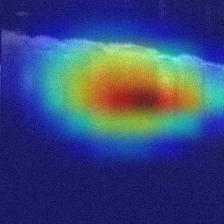

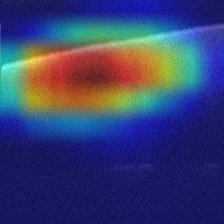

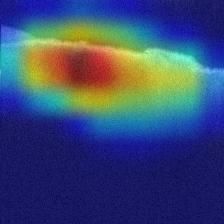

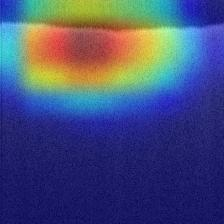

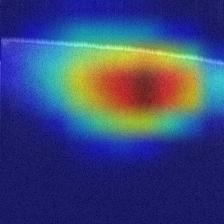

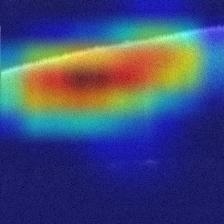

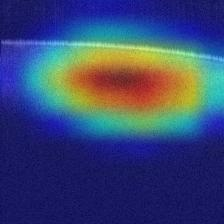

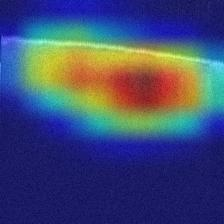

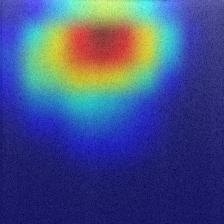

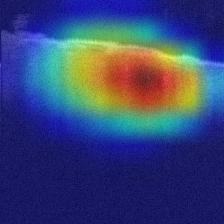

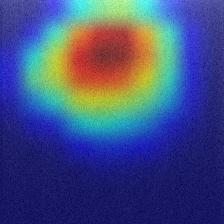

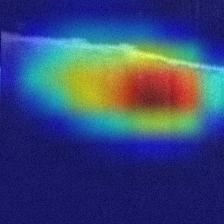

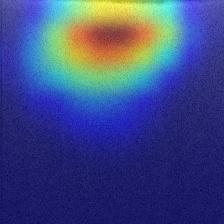

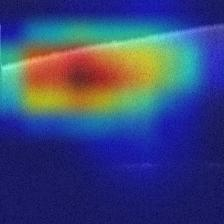

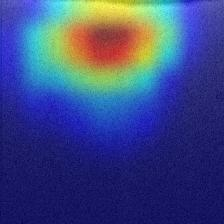

In [ ]:
import glob

# Process all images in the specified directory
# imgs_path = glob.glob(r'E:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_8_13\test_png\nor\*.png')
imgs_path = glob.glob(r'E:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_8_13\test_FOR_YOUR_LIFE\nor_png\*.png')
model_builder = xception.Xception  # Replace with your model
last_conv_layer_name = 'block14_sepconv2_act'  # Replace with the name of the last convolutional layer in your model
preprocess_input = xception.preprocess_input


#建存cam影像目錄
# cam_path = r'E:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_8_13\test_png\nor_CAM'
cam_path = r'E:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_8_13\test_FOR_YOUR_LIFE\nor_CAM'
os.makedirs(cam_path, exist_ok=True)


# Loop through all image paths and generate Grad-CAM for each
for img_path in imgs_path:
    img_name = extract_image_name(os.path.basename(img_path))
    cam_output_path = os.path.join(cam_path, f'{img_name}_cam.jpg')
    generate_and_display_gradcam(img_path, model_builder, last_conv_layer_name, preprocess_input, cam_path=cam_output_path)

處理cal

大函式解體，分別執行小函式(方便觀察)

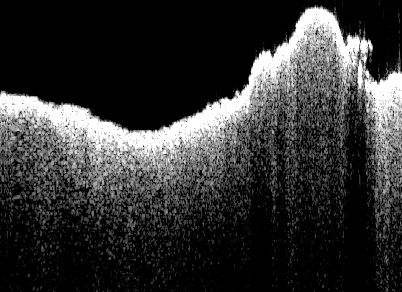

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from IPython.display import Image as IPImage, display

model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
last_conv_layer_name = "block14_sepconv2_act"
output_png_path = r'\\BOIL-NAS\home\Dental OCT\tooth_data_png\201903220033.png'

# 打开 TIFF 文件

#display(IPImage(img_path))  # 秀原圖
display(IPImage(output_png_path))


"""利用load_img載入圖像並用img_to_array轉成array，並擴展維度，跟pretrained好的Xception model互相匹配"""
def get_img_array(img_path, size):
    ## `img` is a PIL image 
    img = load_img(img_path, target_size=size)
    array = img_to_array(img)
    ## We add a dimension to transform our array into a "batch" : because model expect input_shape:(batch_size, height, width, channels)
    array = np.expand_dims(array, axis=0)
    return array

"""從輸入映射到輸出"""
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    ## First, we create a model that maps the input image to the activations
    ## of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    ## Then, we compute the gradient of the top predicted class for our input image
    ## for the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    ## We are doing transfer learning on last layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    ## This is a vector where each entry is the mean intensity of the gradient : use global average pooling
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))


    ## calculates a heatmap highlighting the regions of importance in an image
    ## for a specific 
    ## predicted class by combining the output of the last convolutional layer
    ## with the pooled gradients.
    last_conv_layer_output = last_conv_layer_output[0]

    #原本算法
    # heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]  # GAP
    # heatmap = tf.squeeze(heatmap)

    # ## For visualization purpose
    # heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    #試看看別種計算grad方式，看是否能降噪
    # 计算CAM
    cam = tf.reduce_sum(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
    cam = tf.nn.relu(cam)

    # 归一化CAM
    heatmap = cam / tf.reduce_max(cam)

    return heatmap.numpy()

In [5]:
## Preparing the image
img_array = preprocess_input(get_img_array(output_png_path, size=img_size))

## Making the model with imagenet dataset
model = model_builder(weights="imagenet")

## Remove last layer's softmax(transfer learning)
model.layers[-1].activation = None

## Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)


Predicted of image: [('n03388043', 'fountain', 5.3040624)]


In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="save_cam_image.jpg", alpha=0.4):
    ## Loading the original image
    img = load_img(img_path)
    img = img_to_array(img)

    ## Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    ## Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    ## Create an image with RGB colorized heatmap
    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    ## Superimpose the heatmap on original image
    Superimposed_img = jet_heatmap * alpha + img
    Superimposed_img = array_to_img(Superimposed_img)

    ## Save the superimposed image
    Superimposed_img.save(cam_path)
   

    ## Displaying Grad CAM
    display(IPImage(cam_path))


save_and_display_gradcam(output_png_path, heatmap)